In [1]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [3]:
# To do multiple transforms we use this:
train_transforms = transforms.Compose([
    # Transform our data to tensors, PyTorch accepts tensors
    transforms.ToTensor(),
    # Normalizing data using mean and std from preprocessing step
    transforms.Normalize(0.49, 0.248),
    # Augmenting data for many reasons:
    # Imbalanced Data, Generalization, Overcoming overfitting, Robustness
    transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1), antialias=True)
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
])

In [4]:
train_dataset = torchvision.datasets.DatasetFolder('Processed/train/', loader=load_file, extensions='npy',
                                                   transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder('Processed/val/', loader=load_file, extensions='npy',
                                                 transform=val_transforms)

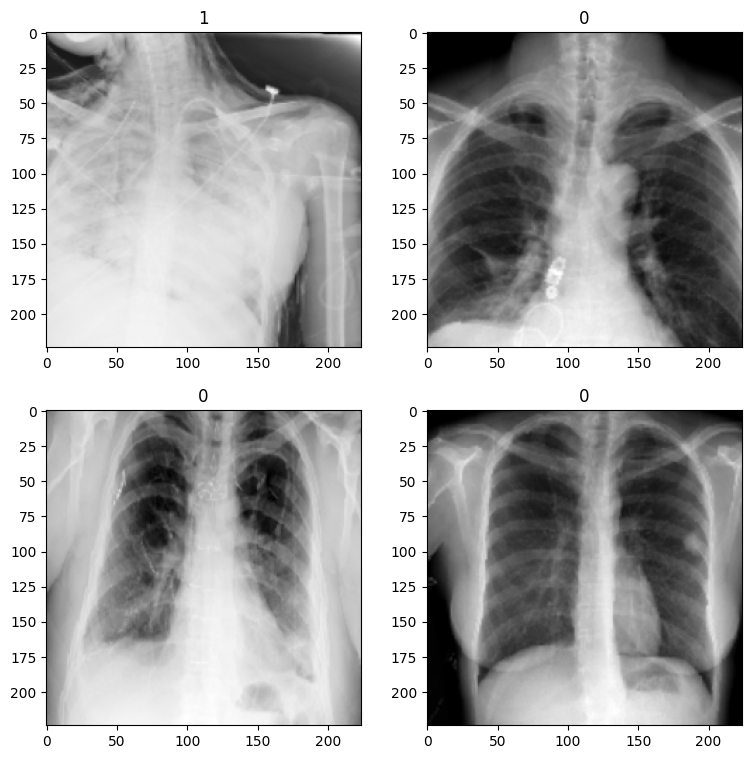

In [5]:
# Plotting some images, we can see the augmentation
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 24000)
        x_ray, label = train_dataset[random_index]
        # torchvision automatically appends a channel dimension in front of all dimensions,
        # so we use x_ray[0]
        axis[i][j].imshow(x_ray[0], cmap='gray')
        axis[i][j].set_title(label)


## Training Model

In [6]:
batch_size = 64
# There's a problem with jupyter, we have to use 0 workers which will take longer to train
num_workers = 0

# Creating data loaders for train and val sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [7]:
# It seems we have imbalanced data, this could be problematic
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407], dtype=int64))

In [8]:
# Let's take a look at ResNet18 model
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
class PneumoniaModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        # Loading ResNet18 base model
        self.model = torchvision.models.resnet18()
        # We only have gray scale, so, 1 channel
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        # Because of imbalanced datasets, we give the negative samples more weight to balance the data, in this case, 3
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))

        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')
        
    # Computing prediction
    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        # We need to remove the second attribute with [:, 0]
        # Prediction shape: batchsize, 1
        # Labels shape : batchsize
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)

        self.log('Train Loss', loss)
        self.log('Step Train ACC', self.train_acc(torch.sigmoid(pred), label.int()))

        # PyTorch lightning uses this loss to update the model parameters
        # This is what PyTorch calls loss.backward() on
        return loss

    def on_train_epoch_end(self):
        self.log('Train ACC', self.train_acc.compute())

    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)

        self.log('Val Loss', loss)
        self.log('Step Val ACC', self.val_acc(torch.sigmoid(pred), label.int()))

    def on_validation_epoch_end(self):
        self.log('Val ACC', self.val_acc.compute())

    def configure_optimizers(self):
        return [self.optimizer]


In [10]:
model = PneumoniaModel()

In [11]:
# Saving the top10 best models
checkpoint_callback = ModelCheckpoint(
    monitor='Val ACC',
    save_top_k=10,
    mode='max',
)

In [12]:
# Where and how to save the models
trainer = pl.Trainer(logger=TensorBoardLogger(save_dir='./logs'), log_every_n_steps=1,
                     callbacks=checkpoint_callback, max_epochs=35)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)
C:\Users\admin\Documents\GitHub\Pneumonia-Classification-PyTorch\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\admin\Documents\GitHub\Pneumonia-Classification-PyTorch\venv\Lib\si

Training: 0it [00:00, ?it/s]

C:\Users\admin\Documents\GitHub\Pneumonia-Classification-PyTorch\venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=35` reached.


In [16]:
# Load and evaluate model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = PneumoniaModel.load_from_checkpoint('checkpoints/epoch=33-step=13125.ckpt')
model.eval()
model.to(device)

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [18]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        # unsqueeze(0) adds a batch axis in front of all axis
        data = data.to(device).float().unsqueeze(0)
        # Remove channel batch dimension and move the data to cpu
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)

preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [ ]:
acc = torchmetrics.Accuracy(task='binary')(preds, labels)
precision = torchmetrics.Precision(task='binary')(preds, labels)
recall = torchmetrics.Recall(task='binary')(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2, task='binary')(preds, labels)

print(f'Val Accuracy {acc}')
print(f'Val Precision {precision}')
print(f'Val Recall {recall}')
print(f'Val ConfusionMatrix {cm}')
# Accuracy is not very helpful alone
# Recall is much larger than Precision, it means our model rarely misses a case of Pneumonia
# But low Precision tells us that many images without Pneumonia is also classified as Pneumonic

Val Accuracy 0.8010432124137878
Val Precision 0.5409457683563232
Val Recall 0.7752066254615784
Val ConfusionMatrix tensor(
[[1681,  398],
                            [ 136,  469]
                            ])